In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Binarizer, MinMaxScaler, FunctionTransformer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import graphviz

In [3]:
df = pd.read_feather('final.feather')
df.head()

,Hydro,Solar,Wind,eia_region,demand_mwh,tavg,wspd,prcp,poa,month_year,label
0,2766.0,1859.0,3334.0,California,2042244.347,11.777419,2.519355,0.338710,887638,2022-01-01,Medium High
1,2322.0,31.0,0.0,Carolinas,2075169.565,4.939785,9.820430,11.667742,776742,2022-01-01,High
2,1304.0,0.0,17695.0,Central,4539319.095,-1.819355,16.219355,1.480645,713940,2022-01-01,High
3,33.0,8.0,0.0,Florida,1813852.253,16.555914,12.197849,6.345161,618925,2022-01-01,Low
4,3044.0,17.0,3494.0,Mid-Atlantic,4413106.059,-1.503226,9.227957,9.493548,637646,2022-01-01,High


# Multinomial NB

In [4]:
df.shape

(113581, 11)

In [3]:
df.columns

Index(['Hydro', 'Solar', 'Wind', 'eia_region', 'demand_mwh', 'tavg', 'wspd',
       'prcp', 'poa', 'month_year', 'label'],
      dtype='object')

In [9]:
def sin_transformer(period: int) -> FunctionTransformer:
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period: int) -> FunctionTransformer:
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def create_sine_cosine_doy_feature(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])
    return df


In [4]:
mnb_df = df.copy()
## Prep data by one-hot encoding `eia_region` and `month_year`, and binning continuous variables into counts as well
### Strip `month_year` to just `month` for one-hot encoding
mnb_df['month'] = mnb_df['month_year'].dt.month
mnb_df.drop(columns=['month_year', 'demand_mwh'], inplace=True)
### Discretize continuous variables
cols = ['Hydro', 'Solar', 'Wind','tavg', 'wspd', 'prcp', 'poa',]
for col in cols:
    mnb_df[col] = pd.cut(mnb_df[col], bins=5, labels=False)
### One-hot encode `eia_region` and `month`
ohe = OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(mnb_df[['eia_region', 'month']])
### Concatentate one-hot encoded columns to dataframe
mnb_df = pd.concat([mnb_df, pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['eia_region', 'month']))], axis=1)
### Drop original columns
mnb_df.drop(columns=['eia_region', 'month'], inplace=True)
mnb_df.head().to_feather('mnb_df_head.feather')


Accuracy: 0.625933230032399
Classification Report:
              precision    recall  f1-score   support

        High       0.75      0.71      0.73      7421
         Low       0.68      0.74      0.71      6678
 Medium High       0.56      0.54      0.55      7400
  Medium Low       0.51      0.52      0.52      6897

    accuracy                           0.63     28396
   macro avg       0.63      0.63      0.63     28396
weighted avg       0.63      0.63      0.63     28396



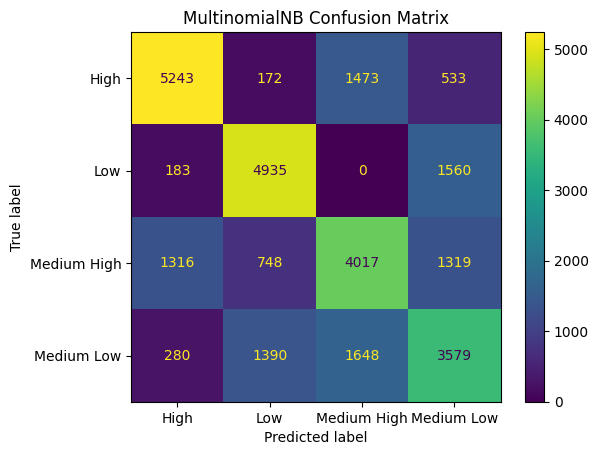

In [5]:
### Split data into training and testing sets
mnb_train_df, mnb_test_df = train_test_split(mnb_df, test_size=0.25, random_state=42)
mnb_train_df.head().to_feather('mnb_train_df.feather')
mnb_test_df.head().to_feather('mnb_test_df.feather')

mnb_x_train = mnb_train_df.drop(columns='label')
mnb_y_train = mnb_train_df['label']

mnb_x_test = mnb_test_df.drop(columns='label')
mnb_y_test = mnb_test_df['label']

mnb = MultinomialNB().fit(mnb_x_train, mnb_y_train)

mnb_y_pred = mnb.predict(mnb_x_test)

accuracy = accuracy_score(mnb_y_test, mnb_y_pred)
report = classification_report(mnb_y_test, mnb_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm = confusion_matrix(mnb_y_test, mnb_y_pred, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb.classes_)
disp.plot()
plt.title('MultinomialNB Confusion Matrix')
plt.savefig('../images/mnb_confusion_matrix.png')
plt.show()

# Guassian NB

Accuracy: 0.48401183265248626
Classification Report:
              precision    recall  f1-score   support

        High       0.51      0.98      0.67      7421
         Low       0.47      0.97      0.63      6678
 Medium High       0.00      0.00      0.00      7400
  Medium Low       0.00      0.00      0.00      6897

    accuracy                           0.48     28396
   macro avg       0.24      0.49      0.32     28396
weighted avg       0.24      0.48      0.32     28396



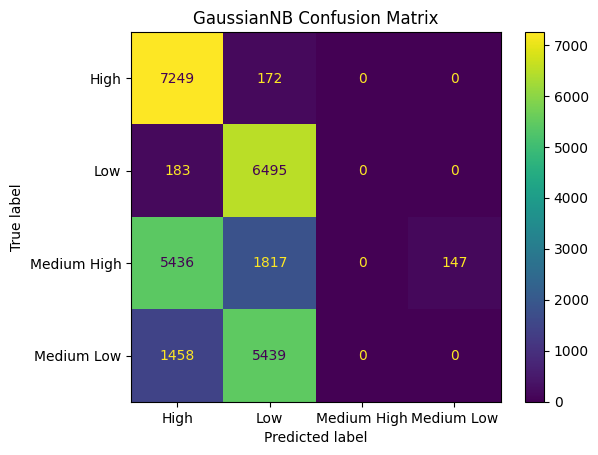

In [6]:
gnb_df = df.copy()
## Prep data by one-hot encoding `eia_region` and `month_year`, and normalizing continuous variables
### Strip `month_year` to just `month` for one-hot encoding
gnb_df['month'] = gnb_df['month_year'].dt.month
gnb_df.drop(columns=['month_year', 'demand_mwh'], inplace=True)
### Normalize continuous variables


X = gnb_df.drop(columns='label')
y = gnb_df['label']

numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_preprocessed = preprocessor.fit_transform(X)

gnb_x_train, gnb_x_test, gnb_y_train, gnb_y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)
pd.DataFrame(gnb_x_train).head().to_feather('gnb_x_train.feather')
pd.DataFrame(gnb_x_test).head().to_feather('gnb_x_test.feather')
gnb_model = GaussianNB().fit(gnb_x_train, gnb_y_train)
gnb_y_pred = gnb_model.predict(gnb_x_test)
accuracy = accuracy_score(gnb_y_test, gnb_y_pred)
report = classification_report(gnb_y_test, gnb_y_pred, zero_division=0)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm = confusion_matrix(gnb_y_test, gnb_y_pred, labels=gnb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb_model.classes_)
disp.plot()
plt.title('GaussianNB Confusion Matrix')
plt.savefig('../images/gnb_confusion_matrix.png')
plt.show()

# Bernoulli NB

Accuracy: 0.698901253697704
Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.78      0.79      7421
         Low       0.76      0.76      0.76      6678
 Medium High       0.65      0.63      0.64      7400
  Medium Low       0.60      0.63      0.61      6897

    accuracy                           0.70     28396
   macro avg       0.70      0.70      0.70     28396
weighted avg       0.70      0.70      0.70     28396



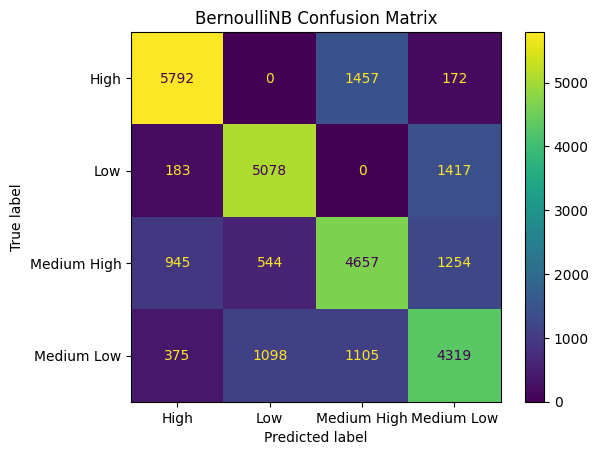

In [7]:
X = gnb_df.drop(columns='label')
y = gnb_df['label']

numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Binarizer())])

categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_preprocessed = preprocessor.fit_transform(X)

bnb_x_train, bnb_x_test, bnb_y_train, bnb_y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)
pd.DataFrame(bnb_x_train).to_feather('bnb_x_train.feather')
pd.DataFrame(bnb_x_test).to_feather('bnb_x_test.feather')

bnb_model = BernoulliNB().fit(bnb_x_train, bnb_y_train)
bnb_y_pred = bnb_model.predict(bnb_x_test)

accuracy = accuracy_score(bnb_y_test, bnb_y_pred)
report = classification_report(bnb_y_test, bnb_y_pred,)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm = confusion_matrix(bnb_y_test, bnb_y_pred, labels=bnb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bnb_model.classes_)
disp.plot()
plt.title('BernoulliNB Confusion Matrix')
plt.savefig('../images/bnb_confusion_matrix.png')
plt.show()


# Decision Tree

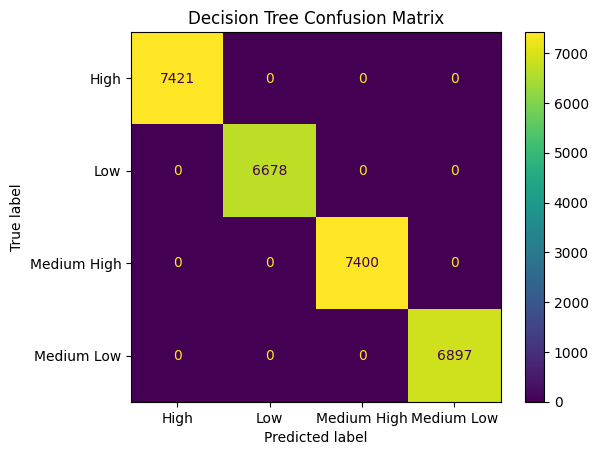

In [ ]:
dt_df = df.copy()
dt_df['month'] = dt_df['month_year'].dt.month
dt_x_df = dt_df.drop(columns='label')
dt_y_df = dt_df['label']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
dt_X_preprocessed = preprocessor.fit_transform(dt_x_df)


dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_X_preprocessed, dt_y_df, test_size=0.25, random_state=42)
pd.DataFrame(dt_x_train).head().to_feather('dt_x_train.feather')
pd.DataFrame(dt_x_test).head().to_feather('dt_x_test.feather')



dt_model = DecisionTreeClassifier().fit(dt_x_train, dt_y_train)
dt_y_pred = dt_model.predict(dt_x_test)

categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + categorical_feature_names

dot_data = export_graphviz(dt_model, out_file=None, feature_names=feature_names, class_names=dt_model.classes_, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('../images/dt_graph', format='png')

cm = confusion_matrix(dt_y_test, dt_y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.title('Decision Tree Confusion Matrix')
plt.savefig('../images/dt_confusion_matrix.png')
plt.show()

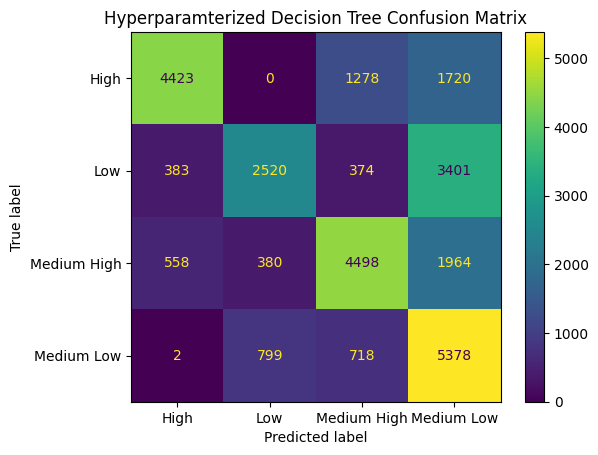

Accuracy: 0.5923017326383998
Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.60      0.69      7421
         Low       0.68      0.38      0.49      6678
 Medium High       0.65      0.61      0.63      7400
  Medium Low       0.43      0.78      0.56      6897

    accuracy                           0.59     28396
   macro avg       0.65      0.59      0.59     28396
weighted avg       0.65      0.59      0.59     28396



In [9]:
dt_no_tavg = dt_df.copy()
dt_x_no_tavg = dt_no_tavg.drop(columns=['label', 'tavg',])
dt_y_no_tavg = dt_no_tavg['label']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = ['Hydro', 'Solar', 'Wind', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region','month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
dt_X_preprocessed = preprocessor.fit_transform(dt_x_no_tavg)


dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_X_preprocessed, dt_y_no_tavg, test_size=0.25, random_state=42)
# pd.DataFrame(dt_x_train).to_feather('dt_x_train.feather')
# pd.DataFrame(dt_x_test).to_feather('dt_x_test.feather')



dt_model = DecisionTreeClassifier(max_depth=6, max_features='sqrt', random_state=42).fit(dt_x_train, dt_y_train)
dt_y_pred = dt_model.predict(dt_x_test)

from sklearn.tree import export_graphviz
import graphviz

categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + categorical_feature_names

dot_data = export_graphviz(dt_model, out_file=None, feature_names=feature_names, class_names=dt_model.classes_, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('../images/dt_graph_no_tavg', format='png')

cm = confusion_matrix(dt_y_test, dt_y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.title('Hyperparamterized Decision Tree Confusion Matrix')
plt.savefig('../images/hyper_dt_confusion_matrix.png')
plt.show()
accuracy = accuracy_score(dt_y_test, dt_y_pred)
report = classification_report(dt_y_test, dt_y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

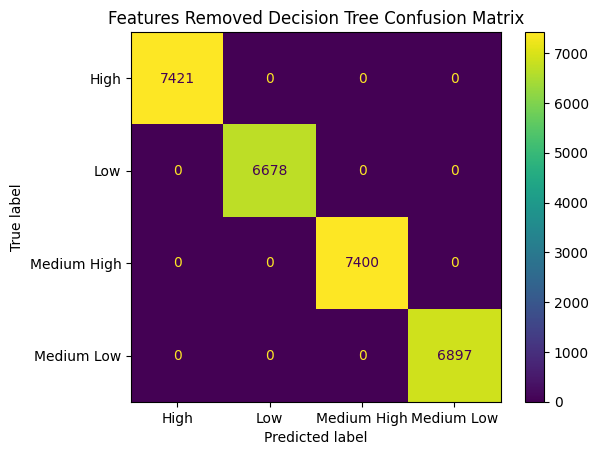

In [10]:
dt_no_month_no_tavg = dt_df.copy()
dt_x_no_month_no_tavg = dt_no_month_no_tavg.drop(columns=['label', 'tavg', 'month'])
dt_y_no_month_no_tavg = dt_no_month_no_tavg['label']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = ['Hydro', 'Solar', 'Wind', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', ]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
dt_X_preprocessed = preprocessor.fit_transform(dt_x_no_month_no_tavg)

dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_X_preprocessed, dt_y_no_month_no_tavg, test_size=0.25, random_state=42)
# pd.DataFrame(dt_x_train).to_feather('dt_x_train.feather')
# pd.DataFrame(dt_x_test).to_feather('dt_x_test.feather')



dt_model = DecisionTreeClassifier().fit(dt_x_train, dt_y_train)
dt_y_pred = dt_model.predict(dt_x_test)

from sklearn.tree import export_graphviz
import graphviz

categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numeric_features + categorical_feature_names

dot_data = export_graphviz(dt_model, out_file=None, feature_names=feature_names, class_names=dt_model.classes_, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('../images/dt_graph_no_tavg_no_month', format='png')

cm = confusion_matrix(dt_y_test, dt_y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.title('Features Removed Decision Tree Confusion Matrix')
plt.savefig('../images/dt2_confusion_matrix.png')
plt.show()

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

/Users/dillonp/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8870967741935484
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     13575
           1       0.90      0.88      0.89     14821

    accuracy                           0.89     28396
   macro avg       0.89      0.89      0.89     28396
weighted avg       0.89      0.89      0.89     28396



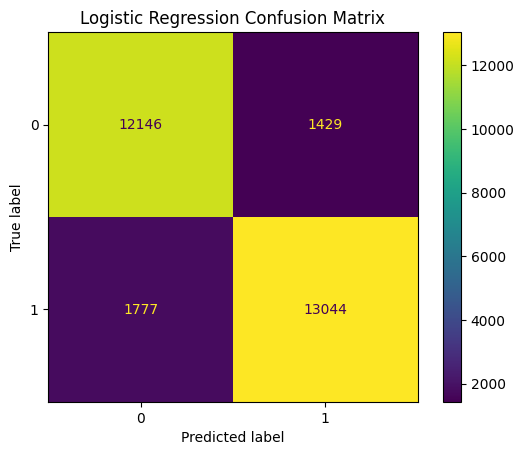

In [12]:
log_df = df.copy()
log_df['month'] = log_df['month_year'].dt.month
log_df['log_label'] = np.where(df.label.isin(['High', 'Medium High']), 1, 0)
log_df.drop(columns='label', inplace=True)
log_x_df = log_df.drop(columns='log_label')
log_y_df = log_df['log_label']

# Define preprocessing for numeric columns (impute missing values and scale)
numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
log_X_preprocessed = preprocessor.fit_transform(log_x_df)
# Split data into training and testing sets
log_x_train, log_x_test, log_y_train, log_y_test = train_test_split(log_X_preprocessed, log_y_df, test_size=0.25, random_state=42)

# # Save the preprocessed training data
pd.DataFrame(log_x_train).to_feather('log_x_train.feather')
pd.DataFrame(log_x_test).to_feather('log_x_test.feather')

# Initialize the model
log_model = LogisticRegression(random_state=42)

# Train the model
log_model.fit(log_x_train, log_y_train)

# Make predictions
log_y_pred = log_model.predict(log_x_test)

# Evaluate the model
accuracy = accuracy_score(log_y_test, log_y_pred)
report = classification_report(log_y_test, log_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

cm = confusion_matrix(log_y_test, log_y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('../images/log_confusion_matrix.png')
plt.show()

## Multinomial NB...again

Accuracy: 0.8676222003099028
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     13575
           1       0.89      0.86      0.87     14821

    accuracy                           0.87     28396
   macro avg       0.87      0.87      0.87     28396
weighted avg       0.87      0.87      0.87     28396



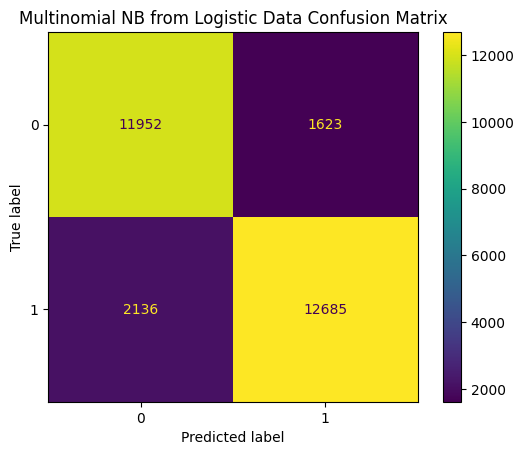

In [13]:
# Define preprocessing for numeric columns (impute missing values and scale to non-negative range)
numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['eia_region', 'month']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
log_X_preprocessed = preprocessor.fit_transform(log_x_df)

# Split data into training and testing sets
log_x_train, log_x_test, log_y_train, log_y_test = train_test_split(log_X_preprocessed, log_y_df, test_size=0.25, random_state=42)

# Train the MultinomialNB model
multi_model = MultinomialNB().fit(log_x_train, log_y_train)
multi_y_pred = multi_model.predict(log_x_test)

# Evaluate the model
accuracy = accuracy_score(log_y_test, multi_y_pred)
report = classification_report(log_y_test, multi_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

cm = confusion_matrix(log_y_test, multi_y_pred, labels=multi_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multi_model.classes_)
disp.plot()
plt.title('Multinomial NB from Logistic Data Confusion Matrix')
plt.savefig('../images/mnb_log_confusion_matrix.png')
plt.show()

# Support Vector Machines

In [36]:
from sklearn.svm import SVC, LinearSVC

Kernel: linear, Cost: 0.1
Accuracy: 0.46238906888294123
Classification Report:
              precision    recall  f1-score   support

        High       0.49      0.76      0.60      7421
         Low       0.39      0.26      0.31      6678
 Medium High       0.42      0.20      0.27      7400
  Medium Low       0.48      0.62      0.54      6897

    accuracy                           0.46     28396
   macro avg       0.44      0.46      0.43     28396
weighted avg       0.45      0.46      0.43     28396



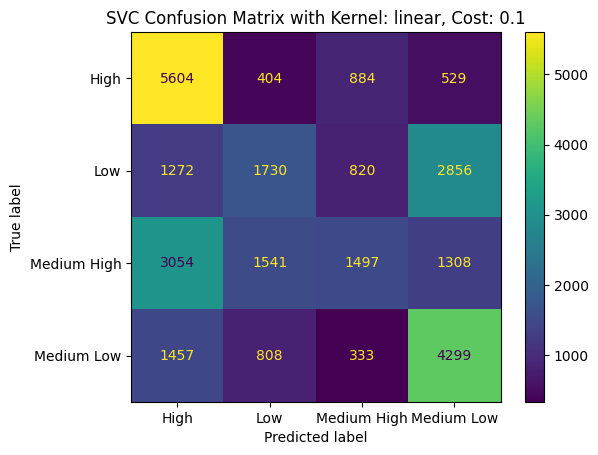

Kernel: linear, Cost: 1
Accuracy: 0.4630581772080575
Classification Report:
              precision    recall  f1-score   support

        High       0.49      0.75      0.60      7421
         Low       0.39      0.26      0.31      6678
 Medium High       0.43      0.20      0.28      7400
  Medium Low       0.48      0.62      0.54      6897

    accuracy                           0.46     28396
   macro avg       0.45      0.46      0.43     28396
weighted avg       0.45      0.46      0.43     28396



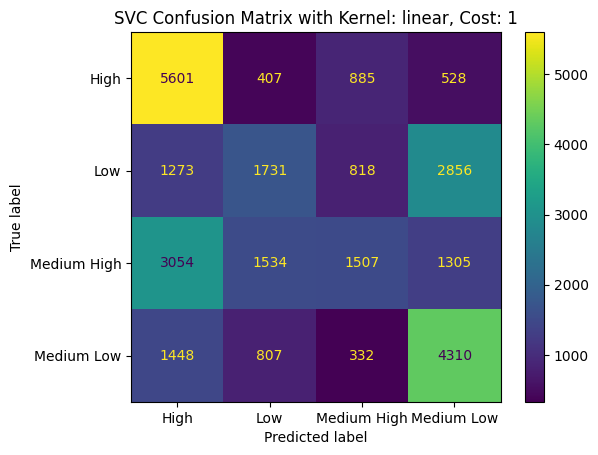

Kernel: linear, Cost: 10
Accuracy: 0.46319904211860824
Classification Report:
              precision    recall  f1-score   support

        High       0.49      0.75      0.60      7421
         Low       0.39      0.26      0.31      6678
 Medium High       0.43      0.20      0.28      7400
  Medium Low       0.48      0.63      0.54      6897

    accuracy                           0.46     28396
   macro avg       0.45      0.46      0.43     28396
weighted avg       0.45      0.46      0.43     28396



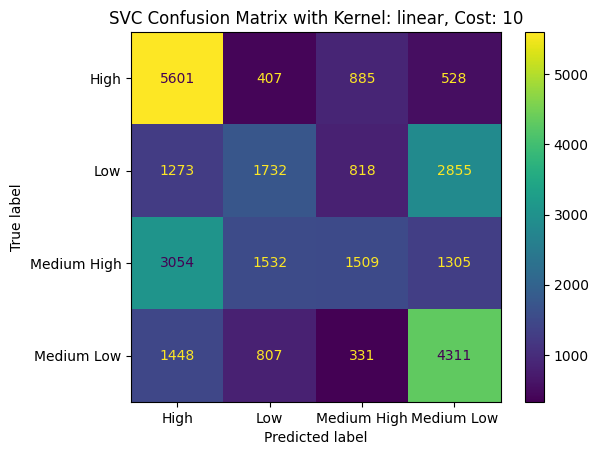

Kernel: poly, Cost: 0.1
Accuracy: 0.9777433441329765
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      7421
         Low       0.97      0.93      0.95      6678
 Medium High       1.00      1.00      1.00      7400
  Medium Low       0.94      0.98      0.96      6897

    accuracy                           0.98     28396
   macro avg       0.98      0.98      0.98     28396
weighted avg       0.98      0.98      0.98     28396



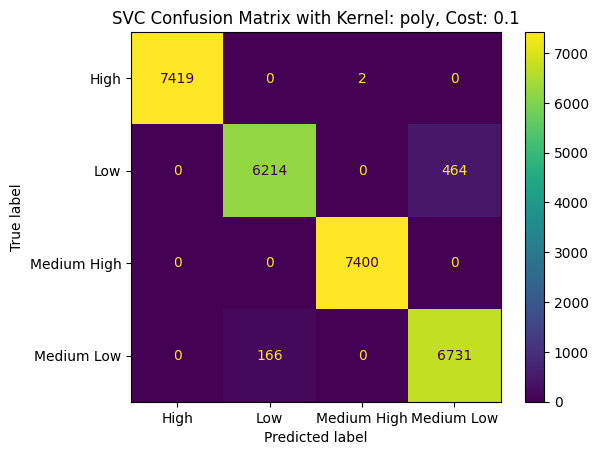

Kernel: poly, Cost: 1
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      7421
         Low       1.00      1.00      1.00      6678
 Medium High       1.00      1.00      1.00      7400
  Medium Low       1.00      1.00      1.00      6897

    accuracy                           1.00     28396
   macro avg       1.00      1.00      1.00     28396
weighted avg       1.00      1.00      1.00     28396



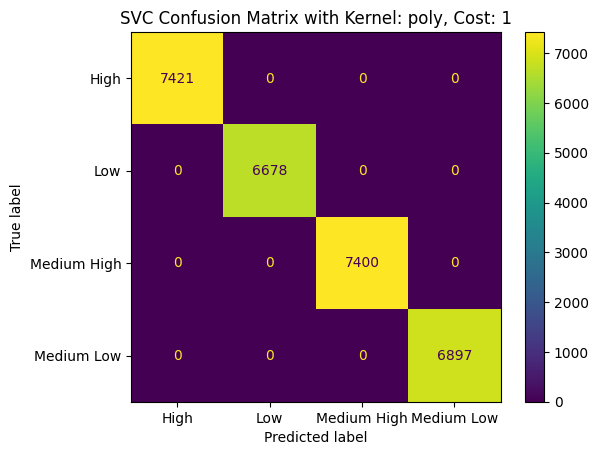

Kernel: poly, Cost: 10
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      7421
         Low       1.00      1.00      1.00      6678
 Medium High       1.00      1.00      1.00      7400
  Medium Low       1.00      1.00      1.00      6897

    accuracy                           1.00     28396
   macro avg       1.00      1.00      1.00     28396
weighted avg       1.00      1.00      1.00     28396



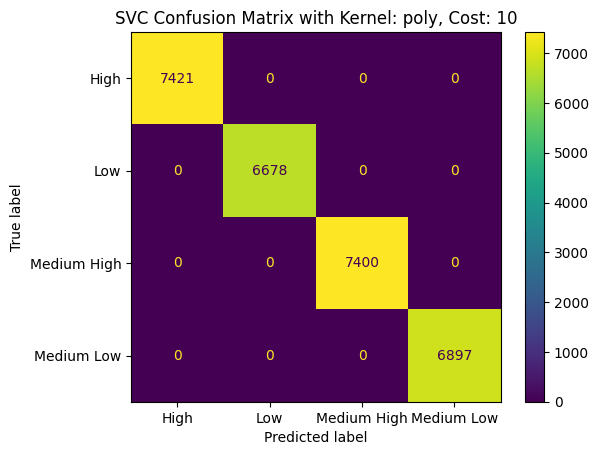

Kernel: rbf, Cost: 0.1
Accuracy: 0.9871108606846035
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      7421
         Low       0.97      0.97      0.97      6678
 Medium High       1.00      1.00      1.00      7400
  Medium Low       0.97      0.97      0.97      6897

    accuracy                           0.99     28396
   macro avg       0.99      0.99      0.99     28396
weighted avg       0.99      0.99      0.99     28396



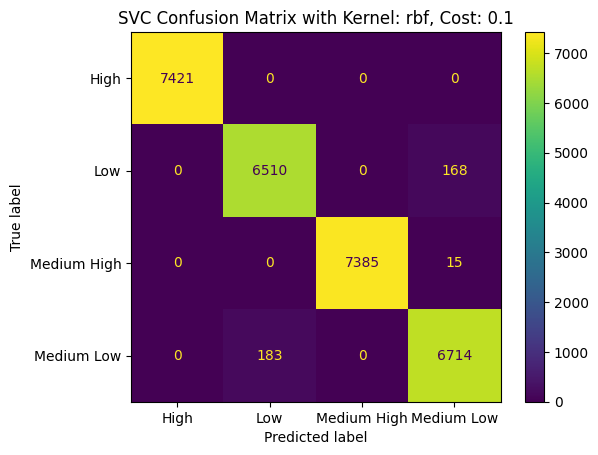

Kernel: rbf, Cost: 1
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      7421
         Low       1.00      1.00      1.00      6678
 Medium High       1.00      1.00      1.00      7400
  Medium Low       1.00      1.00      1.00      6897

    accuracy                           1.00     28396
   macro avg       1.00      1.00      1.00     28396
weighted avg       1.00      1.00      1.00     28396



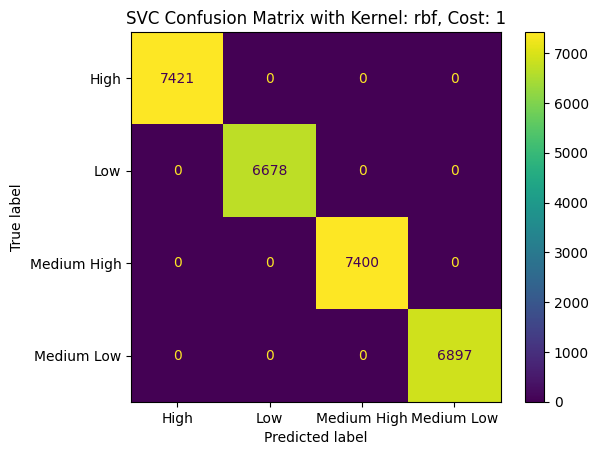

Kernel: rbf, Cost: 10
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      7421
         Low       1.00      1.00      1.00      6678
 Medium High       1.00      1.00      1.00      7400
  Medium Low       1.00      1.00      1.00      6897

    accuracy                           1.00     28396
   macro avg       1.00      1.00      1.00     28396
weighted avg       1.00      1.00      1.00     28396



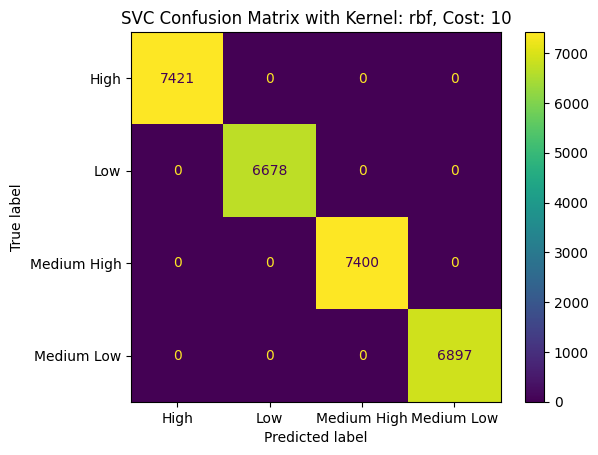

Kernel: sigmoid, Cost: 0.1
Accuracy: 0.3164530215523313
Classification Report:
              precision    recall  f1-score   support

        High       0.44      0.57      0.50      7421
         Low       0.24      0.27      0.25      6678
 Medium High       0.23      0.18      0.20      7400
  Medium Low       0.31      0.23      0.27      6897

    accuracy                           0.32     28396
   macro avg       0.30      0.31      0.30     28396
weighted avg       0.30      0.32      0.31     28396



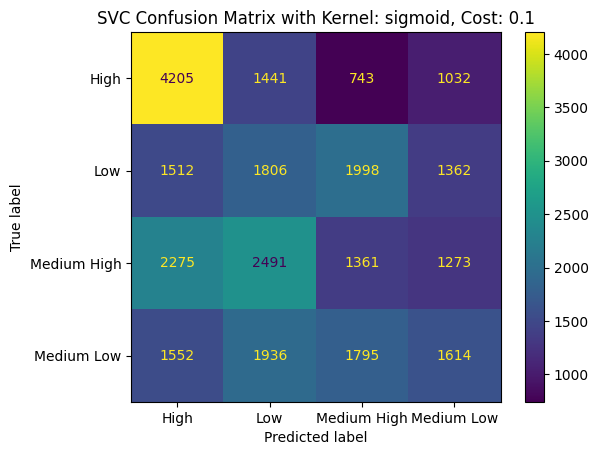

Kernel: sigmoid, Cost: 1
Accuracy: 0.31620650795886746
Classification Report:
              precision    recall  f1-score   support

        High       0.45      0.57      0.51      7421
         Low       0.23      0.27      0.25      6678
 Medium High       0.23      0.18      0.20      7400
  Medium Low       0.30      0.24      0.27      6897

    accuracy                           0.32     28396
   macro avg       0.30      0.31      0.30     28396
weighted avg       0.30      0.32      0.31     28396



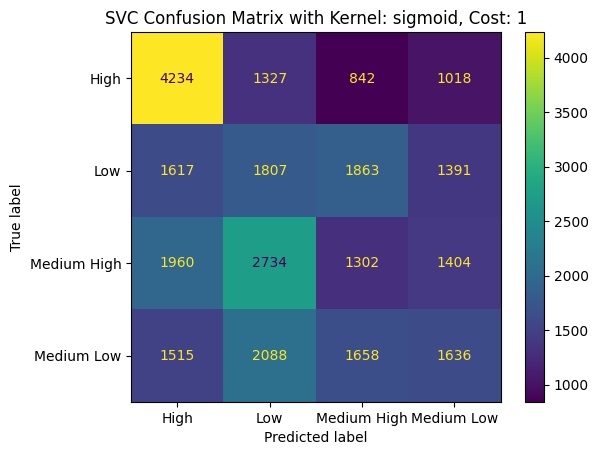

Kernel: sigmoid, Cost: 10
Accuracy: 0.3017678546274123
Classification Report:
              precision    recall  f1-score   support

        High       0.43      0.42      0.42      7421
         Low       0.23      0.28      0.25      6678
 Medium High       0.22      0.23      0.23      7400
  Medium Low       0.36      0.27      0.31      6897

    accuracy                           0.30     28396
   macro avg       0.31      0.30      0.30     28396
weighted avg       0.31      0.30      0.30     28396



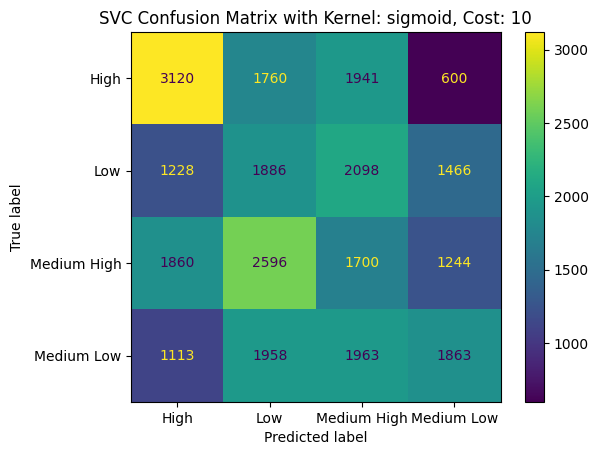

In [ ]:


svm_df = df.copy()
svm_df = create_sine_cosine_doy_feature(svm_df, 'month_year')
# svm_df['demand_quantile'] = pd.qcut(svm_df['demand_mwh'], q=5)
svm_df.drop(columns=['month_year', 'month', 'year', 'demand_mwh'], inplace=True)

svm_df.head()

X = svm_df.drop(columns='label')
y = svm_df['label']

numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa', 'month_sin', 'month_cos']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['eia_region']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)
pd.DataFrame(X_train).to_feather('svm_X_train.feather')
pd.DataFrame(X_test).to_feather('svm_X_test.feather')

list_of_costs = [0.1, 1, 10]
list_of_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in list_of_kernels:
    for cost in list_of_costs:
        if kernel == 'linear':
            svc = LinearSVC(random_state=42, C=cost)
        else:
            svc = SVC(random_state=42, C=cost, kernel=kernel)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print(f'Kernel: {kernel}, Cost: {cost}')
        print(f'Accuracy: {accuracy}')
        print(f'Classification Report:\n{report}')
        cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
        disp.plot()
        plt.title(f'SVC Confusion Matrix with Kernel: {kernel}, Cost: {cost}')
        plt.savefig(f'../images/svc_{kernel}_{cost}_confusion_matrix.png')
        plt.show()

In [ ]:
# from sklearn.decomposition import PCA
# pca_df = df[['Hydro','Solar','Wind','tavg','wspd','prcp','poa','month_year']].copy()
# pca_df = create_sine_cosine_doy_feature(pca_df, 'month_year')
# pca_df.drop(columns=['month_year', 'month', 'year'], inplace=True)
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(X=pca_df)
# pca_n3 = PCA(n_components=3)
# pca_3 = pca_n3.fit_transform(scaled_data)
# y_labels = df['label']
# pca_3.shape[0] == y_labels.shape[0]
# cost = 0.1
# kernel = 'poly'
# X_train, X_test, y_train, y_test = train_test_split(pca_3, y_labels, test_size=0.25, random_state=42)
# svc = SVC(random_state=42, C=cost, kernel=kernel)
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# print(f'Accuracy: {accuracy}')



# from mpl_toolkits.mplot3d import Axes3D
# # Create a mesh grid for plotting decision boundaries
# x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
# y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
# z_min, z_max = X_pca[:, 2].min() - 1, X_pca[:, 2].max() + 1
# xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 50),
#                          np.linspace(y_min, y_max, 50),
#                          np.linspace(z_min, z_max, 50))

# # Predict on the mesh grid
# grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
# pred = svm.decision_function(grid)
# pred = pred.reshape(xx.shape)

# # Plot the decision boundary and data points
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Plot decision boundary
# ax.contour3D(xx, yy, zz, pred, levels=[0], colors='k', linestyles='solid')

# # Plot data points
# scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y.codes, cmap=plt.cm.viridis, s=50)
# legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
# ax.add_artist(legend1)

# ax.set_xlabel('PCA Component 1')
# ax.set_ylabel('PCA Component 2')
# ax.set_zlabel('PCA Component 3')
# ax.set_title('3D SVM Decision Boundary')

# plt.show()

# RANDOM FOREST

Accuracy: 0.9320326806592478
Classification Report:
              precision    recall  f1-score   support

        High       0.99      0.96      0.97      7421
         Low       0.85      0.94      0.89      6678
 Medium High       0.95      0.94      0.95      7400
  Medium Low       0.94      0.89      0.91      6897

    accuracy                           0.93     28396
   macro avg       0.93      0.93      0.93     28396
weighted avg       0.93      0.93      0.93     28396



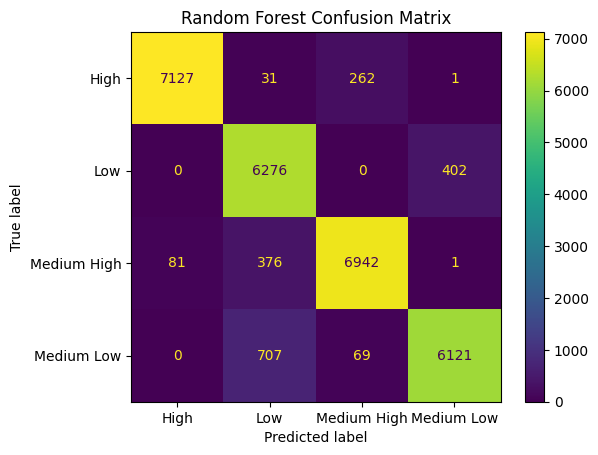

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_df = df.copy()
rf_df = create_sine_cosine_doy_feature(rf_df, 'month_year')
label_order = ['Low', 'Medium Low', 'Medium High', 'High']
rf_df['label'] = pd.Categorical(rf_df['label'], categories=label_order, ordered=True)
# svm_df['demand_quantile'] = pd.qcut(svm_df['demand_mwh'], q=5)
rf_df.drop(columns=['month_year', 'month', 'year', 'demand_mwh'], inplace=True)

rf_df.head()

X = rf_df.drop(columns='label')
y = rf_df['label']

# y_encoded = LabelEncoder().fit_transform(y)

numeric_features = ['Hydro', 'Solar', 'Wind', 'tavg', 'wspd', 'prcp', 'poa', 'month_sin', 'month_cos']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['eia_region']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.25, random_state=42)

rf_model = RandomForestClassifier(criterion='gini', max_depth=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=rf_model.classes_)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.savefig('../images/rf_confusion_matrix.png')
plt.show()

In [19]:
# names_in = rf_model.feature_names_in_
important_features = rf_model.feature_importances_
# print(names_in)
print(important_features)

[0.0159096  0.00179151 0.01380999 0.28117237 0.09332517 0.08297065
 0.11921124 0.19634576 0.14399031 0.00214197 0.00238084 0.00109417
 0.00542409 0.00142809 0.00113581 0.01236181 0.00277169 0.00821819
 0.00555075 0.00245512 0.00320308 0.00330778]


In [40]:
trees = [rf_model.estimators_[0], rf_model.estimators_[1],  rf_model.estimators_[2]]

for i, tree in enumerate(trees):
# Visualize the decision tree
    dot_data = export_graphviz(tree, out_file=None, 
                            feature_names=numeric_features + preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features).tolist(), 
                            class_names=label_order, 
                            filled=True, rounded=True, 
                            special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render(f'../images/random_forest_graph{i}', format='png')
# graph.view()